In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## The basic model of virus dynamics

The basic model for virus dynamics is:

$$ \dot{x} = \lambda - d x - \beta x v $$
$$ \dot{y} = \beta x v - a y $$
$$ \dot{v} = ky - uv $$

where $\lambda$ is the constant rate of replishment of susceptible cells, $d$ is the death rate of susceptible cells, $a$ is the death rate of infected cells, $u$ is the clearance rate of virus, $k/a$ is the burst size (# of viruses produced by infected cells over their lifespan), and $\beta$ is the per contact rate at which susceptible cells become infected by virus.

## Steady state assumption for $v$

If $u >> a$, then to a good approximation, $v$ is in a steady state ($\dot{v} = 0$). In that case, the viral load is proportional to the concentration of infected cells $v = k y / u$. Let $b = \beta k / u$, then we have the reduced system:

$$ \dot{x} = \lambda - dx - b x y$$
$$ \dot{y} = b x y - ay $$

(This is all directly as written in Nowak Virus Dynamics 10.4-10.5.) Below we will refer to this as the $v$ steady-state model.

In [26]:
from reactionmodel.model import Species, Reaction, Model

x  = Species('x')
y = Species('y')

reactions = []
reactions.append(Reaction([x], [], k='d'))
reactions.append(Reaction([], [x], k='l'))
reactions.append(Reaction([y], [], k='a'))
reactions.append(Reaction([x, y], [(y, 2)], k='b'))

m_v_steady = Model([x, y], reactions)

## Drug resistant mutant

Suppose that there are two strains of the virus $y_s$ and $y_r$, the former which is susceptible to an anti-viral drug and the latter which is resistant. Then our system, with the steady-state approximation for $v$, becomes:

$$ \dot{x} = \lambda - d x - (s b_s y_s + b_r y_r) x $$
$$ \dot{y_s} = (s b_s x - a) y_s $$
$$ \dot{y_r} = (b_r x - a) y_r $$

where $s \in [0, 1]$ is a parameter that characterizes the drug's inhibition of infection of susceptibles by the sensitive virus.

So far, this is all exactly as written in Novak 2000. Let us introduce the additional term of a mutation rate $\mu << 1$, where mutation occurs at the point of infection:

$$ \dot{x} = \lambda - d x - (s b_s y_s + b_r y_r) x $$
$$ \dot{y_s} = (s b_s (1 - \mu) x - a) y_s \approx (s b_s x - a) y_s $$
$$ \dot{y_r} = (b_r x + s b_s \mu - a) y_r $$

We will refer to this as the $v$ steady-state model with drug.

In [27]:
ys = Species('y_s')
yr = Species('y_r')

reactions = []
reactions.append(Reaction([x], [], k='d'))
reactions.append(Reaction([], [x], k='l'))
reactions.append(Reaction([ys], [], k='a'))
reactions.append(Reaction([yr], [], k='a'))
reactions.append(Reaction([x, ys], [(ys, 2)], k='s*b_s'))
reactions.append(Reaction([x, yr], [(yr, 2)], k='b_r'))
reactions.append(Reaction([x, ys], [ys, yr], k='s*b_s*mu'))

m_v_steady_with_drug = Model([x, ys, yr], reactions)


## Latency

A topic of huge importance in the context of HIV is the latent reservoir: quiescent CD4+ T-cells that harbor HIV virus in their genome. These cells can (1) **reactivate** from the quiescent state and produce new virus particles and (2) be **seeded** by actively infected cells that enter the quiescent state and (3) **die**, at a much slower rate ($<< \lambda$) than an active CD4+ T-cell. Because of these long-lived latently infected cells, HIV cannot be cured through ART. 

Later, we will consider a model of virus dynamics that incorporates latency in all its parts, but latency has a notable effect that is both (a) important to capture in our simulation approach (b) helpful in designing tests of our simulation approach: due to reactivation from latency, infected cell populations will not decline to 0 copies / mL even in the presence of a drug that is 100% effective in inhibiting new infections, as some number of actively infected cells will be sustained in the bloodstream as they "wake up" from the quiescent state. Due to this phenomenon, viral loads (proxied in the $v$ steady-state model by numbers of infected cells) will hover at low levels, where stochastic fluctuations matter the most. On the timescales of interest, the size of the latent reservoir will not meaningfully decline (half life of ~1,300 days). Therefore we will model this effect with a small zeroeth birth rate for wildtype infected cells:

$$ \dot{y_s} = (s b_s x - a) y_s + \eta$$

Whenever this $\eta$ term is included, we will say it is a model with "constant reactivation." We ignore reactivation of latently infected *resistant* cells (for now).

In [28]:
reactions.append(Reaction([], [ys], k='eta'))

m_v_steady_with_drug_and_reactivation = Model([x, ys, yr], reactions)

## Experiments

### Probability / unit time of mutant emergence

Our simplest experiment is also one of our most important. Suppose that the viral load of wildtype viruses is (a) suppressed by the administration of a drug that reduces $R_0 < 1$ but (b) sustained at a low level by constant reactivation from the latent reservoir. Suppose also that there are zero initial copies of the drug resistant mutant.

What is the probability per unit time that a drug resistant mutant emerges and escapes stochastic extinction?

The answer obviously depends on the exact parameters. To clarify how the virus dynamics parameters inform the answer, we adjust our parametrization by introducing the following parameters: equilibrium viral load $y^*$ with drug present, the fraction of that equilibrium viral load that is sustained by replication (as opposed to reactivation) $f_\text{rep}$, the basic reproductive number of the mutant virus $R_\mu$. These replace some of our existing parameters in the following fashion:


$$ s \cdot b_s = \frac{a f_\text{rep} d}{\lambda} $$
$$ b_r = \frac{a R_\mu d}{\lambda} $$
$$ \eta = y^* a (1 - f_\text{rep}) $$

Leaving us with the following revision of the dynamical system (note that we have shed one parameter because $s$ and $b_s$ always appeared as a product):

$$ \dot{x} = \lambda - d x - \left(\frac{a f_\text{rep} d}{\lambda} y_s + \frac{a R_\mu d}{\lambda} y_r\right) x $$
$$ \dot{y_s} = \left(\frac{a f_\text{rep} d}{\lambda} x - a\right) y_s + y^* a (1 - f_\text{rep})$$
$$ \dot{y_r} = \left(\frac{a R_\mu d}{\lambda} x + \frac{a f_\text{rep} d \mu}{\lambda} - a\right) y_r $$

Mutants are generated at a rate of $a f_\text{rep} \mu y^*$. A single mutant introduced at equilibrium infects target cells at a rate $a R_\mu$

If this question turns out to be hard to ask our simulator, let us instead ask: What is the distribution of times until a resistant mutant emerges and escapes stochastic extinction?

In [29]:
from dataclasses import dataclass

@dataclass
class MutantEmergenceParameters():
    d: float
    a: float
    l: float
    y0: float
    f_rep: float
    mu: float
    R_mu: float

    def __post_init__(self):
        print(f"Mutant generation rate: {self.a*self.f_rep*self.mu*self.y0:0.3f}")
        print(f"Mutant infection rate at eq: {self.a*self.R_mu}")
        print(f"Maximum implied s: {self.to_standard()['s']:0.3f}")

    def initial(self):
        initial = {
            'x' : self.l / self.d,
            'y_s': self.y0,
            'y_r': 0,
        }
        return initial

    def to_standard(self):
        initial = self.initial()
        standard = {
            'd' : self.d,
            'a' : self.a,
            'l' : self.l,
            'mu': self.mu
        }
        standard['b_r'] = self.a * self.R_mu / initial['x']
        # we manage to reduce our # of parameters by 1, because s * b_s always appear in combination
        standard['b_s'] = standard['b_r']
        s_b_s_product = self.a * self.f_rep / initial['x']
        standard['s'] = s_b_s_product / standard['b_r']
        standard['eta'] = self.y0 * self.a * (1 - self.f_rep)

        return standard

    def to_gillespie_compatible_parameters(self):
        pass

m = m_v_steady_with_drug_and_reactivation
p = MutantEmergenceParameters(**{
    'd': 0.05,
    'a': 1.0,
    'l': 1e10,
    'mu': 1e-6,
    'R_mu': 1.5,
    'y0': 1e5,
    'f_rep': 0.5
})

Mutant generation rate: 0.050
Mutant infection rate at eq: 1.5
Maximum implied s: 0.333


In [30]:
params = p.to_standard()
initial = m.make_initial_condition(p.initial(), parameters=params)

In [31]:
from scipy.integrate import solve_ivp
t_eval = np.linspace(0, 120, 121)

result = solve_ivp(m.get_dydt(jit=False, parameters=params), [0.0, 120.0], initial, t_eval=t_eval)

Evaluating expression: d => 0.05
Evaluating expression: l => 10000000000.0
Evaluating expression: a => 1.0
Evaluating expression: a => 1.0
Evaluating expression: s*b_s => 2.5e-12
Evaluating expression: b_r => 7.5e-12
Evaluating expression: s*b_s*mu => 2.4999999999999998e-18
Evaluating expression: eta => 50000.0


In [32]:
df = pd.DataFrame(index=result.t, data={name:v for name, v in zip(m.legend(), result.y)})

In [33]:
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner

s = HybridSimulator(
    m.get_k(parameters=params, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    FixedThresholdPartitioner(100.0),
)

Evaluating expression: d => 0.05
Evaluating expression: l => 10000000000.0
Evaluating expression: a => 1.0
Evaluating expression: a => 1.0
Evaluating expression: s*b_s => 2.5e-12
Evaluating expression: b_r => 7.5e-12
Evaluating expression: s*b_s*mu => 2.4999999999999998e-18
Evaluating expression: eta => 50000.0


In [34]:
hybrid_df = pd.DataFrame()
for i in range(500):
    result = s.simulate([0.0, 120.0], initial, np.random.default_rng(), t_eval=t_eval)
    y_r = result.y_history[m.legend().index('y_r')]
    r = pd.Series(data=y_r, index=result.t_history)
    r = r[t_eval]
    r.name = f'_r{i}'
    hybrid_df = pd.concat([hybrid_df, r], axis=1)

(1, 1000000000000.0)

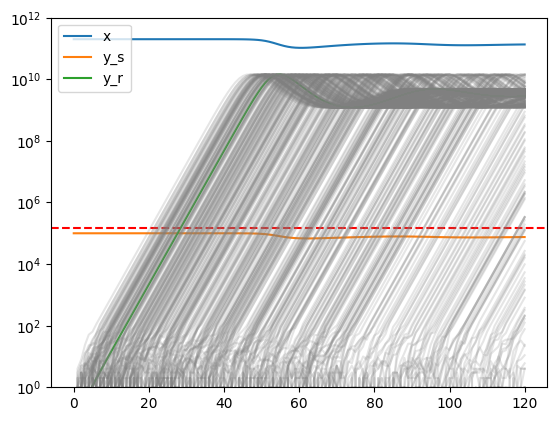

In [35]:
ax = df.plot(logy=True)
ax.axhline(3000*50, linestyle='--', color='r')
hybrid_df.plot(ax=ax, colormap=lambda x: 'grey', alpha=0.2)
ax.set_ylim([1, 1e12])

In [36]:
from hybrid.tau import TauLeapSimulator

s = TauLeapSimulator(
    m.get_k(parameters=params, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    critical_threshold=200,
    #only_reactants_critical=False
    #species_creation_is_critical=True
)

Evaluating expression: d => 0.05
Evaluating expression: l => 10000000000.0
Evaluating expression: a => 1.0
Evaluating expression: a => 1.0
Evaluating expression: s*b_s => 2.5e-12
Evaluating expression: b_r => 7.5e-12
Evaluating expression: s*b_s*mu => 2.4999999999999998e-18
Evaluating expression: eta => 50000.0


In [ ]:
tau_df = pd.DataFrame()
for i in range(500):
    result = s.simulate([0.0, 120.0], initial, np.random.default_rng(), t_eval=t_eval)
    y_r = result.y_history[m.legend().index('y_r')]
    r = pd.Series(data=y_r, index=result.t_history)
    r = r[t_eval]
    assert(len(r) == len(t_eval))
    r.name = f'_r{i}'
    tau_df = pd.concat([tau_df, r], axis=1)

In [38]:
result.status_counter

Counter({<TauStepStatus.leap: 0>: 5255,
         <TauStepStatus.leap_critical_combined: 1>: 428})

(1, 1000000000000.0)

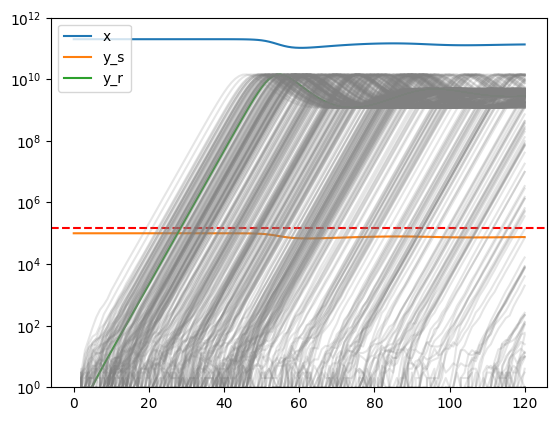

In [39]:
ax = df.plot(logy=True)
ax.axhline(3000*50, linestyle='--', color='r')
tau_df.plot(ax=ax, colormap=lambda x: 'grey', alpha=0.2)
ax.set_ylim([1, 1e12])

### Mathematical analysis

If $R_\mu$ is bounded away from $1$, then the establishment of the resistant mutant will occur while the populations of target cells and wildtype infected cells are very close to their equilibrium values ($x^*$ and $y^*$, respectively). For example, if $R_\mu = 1.1$, a population of 100 resistant mutants will go extinct with probability 7e-5. If we neglect stochastic fluctuations of $y_s$ and $x$ around their equilibrium values (the reasonableness of this choice will be discussed below), then the population of the resistant mutant obeys a linear birth-death process with immigration.

In 1958, Karlin and McGregor described the solution for the transition probability matrix $P_{ij} \equiv \text{Pr} \{ x(t) = j | x(0) = i \}$ for this process. (N.b., the formula below is only valid for $i \le j$, but there is any easy transformation to obtain the $i > j$ probabilities, the formula below is only valid for a linear term of birth rate that exceeds the linear term of death rate and that in this case $n \lambda$ is the death rate and $(n + \beta) \mu$ is the birth rate, and in the formula below $(x)_n$ denotes the [falling factorial](https://en.wikipedia.org/wiki/Falling_and_rising_factorials) of $x$):

TKTK: or is () the Pochhammer symbol? I think that makes more sense

$$ P_{ij} (t) = \left( \frac{\lambda}{\mu} \right)^{i + j} (1 - \gamma)^{-\beta} \pi_j \frac{j!}{(\beta)_j} \left(1 - \sigma/\gamma \right)^i (1 - \sigma)^{-i - \beta} e^{-(\mu - \lambda)\beta t} \times \sum_{k=0}^i {i \choose k} (-1)^k \left[\frac{1 - \frac{\sigma}{\gamma^2}}{1 - \frac{\sigma}{\gamma}}\right]^k \left[ \frac{1 - \frac{\sigma}{\gamma}}{1 - \sigma}\right]^{j-k} \frac{(i + \beta)_{j-k}}{(j - k)!}$$

where

$$ (n + \beta) \mu = \text{birth rate} $$
$$ n \lambda = \text{death rate} $$
$$ \pi_n = \left(\frac{\lambda}{\mu}\right)^n \cdot \frac{(\beta)_n}{n!} $$
$$ \sigma = \frac{\lambda}{\mu} e^{- (\mu - \lambda)t} $$
$$ \gamma = \frac{\lambda}{\mu} $$

We are concerned with the transition probabilities where $i = 0$, which are dramatically simpler:

$$ P_{0j} (t) = \pi_j \left( \frac{\lambda}{\mu} \right)^{j} \left(1 - \frac{\lambda}{\mu}\right)^{-\beta} \left( 1 - \frac{\mu \sigma}{\lambda} \right)^j (1 - \sigma)^{-j - \beta} e^{-(\mu - \lambda)\beta t}.$$

You can see that as t => 0, the term with the power of $j$ ensures that $P_{0j}$ goes to 0 if $j != 0$. For $j = 0$, we have $0^0$, which is undefined, but we can see by inspection that $P_{00} (0) = 1$ as all other terms are 0 and the total probability must sum to 1.

Recall 
$$ P_{0j} (t) = \pi_j \left( \frac{\lambda}{\mu} \right)^{j} \left(1 - \frac{\lambda}{\mu}\right)^{-\beta} \left( 1 - \frac{\mu \sigma}{\lambda} \right)^j (1 - \sigma)^{-j - \beta} e^{-(\mu - \lambda)\beta t}.$$

In which case:

$$ P_{00} (t) = \left[\left( 1 - \frac{\lambda}{\mu} \right)(1 - \sigma)\right]^{-\beta} e^{-(\mu - \lambda) \beta t} \qquad t \ne 0 $$

In the limit $t \to 0$ from above, we can Taylor expand:

$$ P_{00} (t) = \left[\left( 1 - \frac{\lambda}{\mu} \right)(1 - \sigma)\right]^{-\beta} e^{-(\mu - \lambda) \beta t} \qquad t \ne 0 $$



and

$$ \log P_{00} (t) = -\beta \left(\log \left( 1 - \frac{\lambda}{\mu} \right) + \log (1 - \sigma) \right) - (\mu - \lambda) \beta t \qquad t \ne 0 $$

which may help us calculate this quantity with less numerical instability.

In [40]:
# Giorno and Nobile (20):

def p00_giorno(t, birth_rate, death_rate, immigration_rate):
    l = birth_rate
    mu = death_rate
    v = immigration_rate

    inside_brackets = (l - mu)/(l * np.exp((l-mu)*(t)) - mu)
    p00 = inside_brackets**(v/l)
    return p00

Text(0, 0.5, '$Pr \\{ y_r = 0 \\}$')

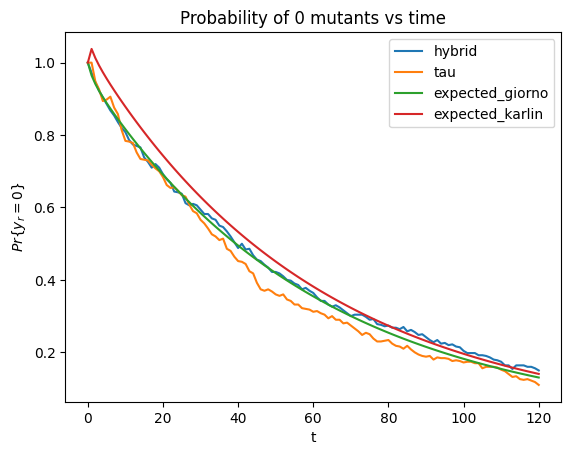

In [41]:
hybrid_fraction = ((hybrid_df == 0).sum(axis=1) / len(hybrid_df.columns))
tau_fraction = ((tau_df == 0).sum(axis=1) / len(tau_df.columns))


def p00(t, mu, l, beta):
    sigma = l/mu * np.exp(-(mu - l) * t)
    #print(sigma[:5])
    #print(np.log(1 - l/mu) + np.log(1 - sigma)[:5])
    #print(((mu - l) * t)[:5])
    log_p00 = -beta * (np.log(1 - l/mu) + np.log(1 - sigma)) - (mu - l) * beta * t
    #print(log_p00[:5])
    return np.exp(log_p00)

probability = p00(t_eval, 1.5, 1.0, 0.05/1.5)
probability[0] = 1.0

probability_g = p00_giorno(t_eval, 1.5, 1.0, 0.05)
probability_g[0] = 1.0


ax = pd.DataFrame(data={'hybrid': hybrid_fraction, 'tau':tau_fraction, 'expected_giorno': probability_g, 'expected_karlin':probability}).plot()
ax.set_title('Probability of 0 mutants vs time')
ax.set_xlabel('t')
ax.set_ylabel('$Pr \{ y_r = 0 \}$')

In [42]:
p00(2.5985659682605218, 1.5, 1.0, 0.05/1.5)

1.0

By Giorno and Nobile (20):

$$ \rho (t | t_0 ) \equiv \frac{e^{(\lambda - \mu)(t - t_0)} - 1}{\lambda e^{(\lambda - \mu)(t - t_0)} - \mu} \qquad \lambda \ne \mu $$

$$ p_{0,n} ( t | t_0) = \left[ \frac{\lambda - \mu}{\lambda e^{(\lambda - \mu)(t - t_0)} - \mu} \right]^{\nu / \lambda} \frac{1}{n!} \left( \frac{\nu}{\lambda} \right)_n [\lambda \rho(t | t_0)]^n $$

$$ p_{0,0} (t | t_0) = \left[ \frac{\lambda - \mu}{\lambda e^{(\lambda - \mu)(t - t_0)} - \mu} \right]^{\nu / \lambda}  \qquad t \ne 0 $$

and let $t_0 = 0$.

In [43]:
mu = 1.5
l = 1.0
gamma = l/mu

np.log((gamma**2 - gamma - 1)/(gamma - 1)) / (mu - l)

2.5985659682605218

In [44]:
(np.log(l) - np.log(mu))/(l - mu)

0.8109302162163288

In [45]:
(gamma**2 - gamma - 1)/(gamma - 1)

3.6666666666666665

In [46]:
t_eval[:5], probability

(array([0., 1., 2., 3., 4.]),
 array([1.        , 1.03792551, 1.01274672, 0.99202086, 0.97346405,
        0.95615332, 0.93964378, 0.92369961, 0.90818843, 0.89303295,
        0.87818659, 0.86362038, 0.84931557, 0.83525949, 0.82144306,
        0.80785936, 0.79450277, 0.78136851, 0.76845225, 0.75575004,
        0.7432581 , 0.73097284, 0.71889075, 0.70700842, 0.69532254,
        0.68382983, 0.6725271 , 0.66141119, 0.65047902, 0.63972754,
        0.62915377, 0.61875477, 0.60852765, 0.59846958, 0.58857774,
        0.57884941, 0.56928187, 0.55987247, 0.55061859, 0.54151767,
        0.53256717, 0.5237646 , 0.51510754, 0.50659356, 0.4982203 ,
        0.48998545, 0.4818867 , 0.47392181, 0.46608857, 0.45838481,
        0.45080837, 0.44335717, 0.43602912, 0.42882219, 0.42173438,
        0.41476373, 0.40790828, 0.40116615, 0.39453546, 0.38801436,
        0.38160105, 0.37529374, 0.36909068, 0.36299015, 0.35699045,
        0.35108991, 0.34528691, 0.33957982, 0.33396706, 0.32844707,
        0.32301831

### A Gillespie compatible version

To compare results from different simulators to some

## Experiments:

- Probability / unit time that a mutant emerges when wildtype is at a low level due to treatment. [Might have to introduce new term to prop it up without latency.]
- Diffusion process: ignore mutation. Given $n$ initial copies of wildtype and $R_0$ of blah (might depend on the absolute magnitudes of the birth/death rates as well), what is the mean and ~~variance~~ [index of dispersion](https://stats.stackexchange.com/questions/203766/use-cases-for-coefficient-of-variation-vs-index-of-dispersion) of the population of the wildtype after $t$ time passes. Maybe the strictest version of this scenario is to start the wildtype at its mean value.
  - variant 1: virus is at low level (survives only due to reactivation from latency)
  - variant 2: virus is at SPVL
  - variant 3: virus is at low level, but $R_0$ jumps to being greater than one at $t = 0$.
- Race to rescue: given $n$ initial copies of wildtype and active inhibition by drug, what is the distribution of times of emergence of a mutant which survives stochastic extinction (a rescue mutant).
- The GOAT experiment: seed $n$ initial copies of wildtype, let it grow [?] until some point in time. Then introduce drug and mutation. What is the probability of a mutant emerges. Depends on (1) inherent large-scale fluctuations in # of infected cells (Langevin regime essentially) (2) low level stochasticity of race to rescue. Am I sure everything doesn't wash out due to reducing observation down to one quantity (probability of emergence). Maybe instead look at the distribution of times that a rescue mutant emerges!

In [47]:
p = {
    'd': 0.05,
    'a': 1.0,
    'l': 1e10,
    's': .33,
    'mu': 1e-5,
    'b_s': 3e-11,
    'b_r': 2e-11,
}

y0 = m.make_initial_condition(
    {
        'x': 'l/d',
        'y_s': 1,
        'y_r': 0
    },
    parameters=p
)

Evaluating expression: l/d => 200000000000.0


In [48]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

result = solve_ivp(m.get_dydt(jit=False, parameters=p), [0.0, 100.0], y0)

ax = plt.subplot()
ax.plot(result.t, result.y.T)
ax.legend([s.name for s in m.species])
ax.set_yscale('log')
ax.set_ylim([1, 1e12])

Evaluating expression: d => 0.05
Evaluating expression: l => 10000000000.0
Evaluating expression: a => 1.0
Evaluating expression: a => 1.0
Evaluating expression: s*b_s => 9.900000000000001e-12
Evaluating expression: b_r => 2e-11
Evaluating expression: s*b_s*mu => 9.900000000000002e-17
Evaluating expression: eta => 

NameNotDefined: 'eta' is not defined for expression 'eta'

In [ ]:
import numpy as np
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner

s = HybridSimulator(
    m.get_k(parameters=p, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    FixedThresholdPartitioner(100.0),
)

result = s.simulate([0.0, 100.0], y0, np.random.default_rng())

ax = plt.subplot()
ax.plot(result.t_history, result.y_history.T)
ax.legend([s.name for s in m.species])
ax.set_yscale('log')
ax.set_ylim([1, 1e12])

In [ ]:
from hybrid.gillespie import GillespieSimulator

GillespieSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
)

### Subquestion:

In [ ]:
a = Species('A')
b = Species('B')
r1 = Reaction([a], [b], k='k')
r2 = Reaction([b], [a], k='k')
m = Model([a, b], [r1, r2])

In [ ]:
import numpy as np
from hybrid.gillespie import GillespieSimulator

parameters = {'k': 1}

s = GillespieSimulator(
    m.get_k(parameters=parameters),
    m.stoichiometry(),
    m.kinetic_order(),
)

result = s.simulate(
    [0.0, 200.0],
    m.make_initial_condition({'A': 200, 'B': 200}),
    rng=np.random.default_rng()
)

Per Gillespie, it's a known rule of thumb in chemistry and a mathematically exact result in the Langevin regime that the fluctuations caused by the mean 0 stochastic effects are on the order of $\sqrt{N}$ for a reaction involving a species with population size $N$, whereas the deterministic part has mean proportional to the population size. Therefore the **ratio** of the stochastic effects to the deterministic ones is $N^{-1/2}$.

"The relative fluctuations in the time-evolving species populations scale as the inverse square-root of the reactant populations." A fact that "follows simply from the fact that the standard deviation of a Poisson random variable is always equal to the square root of its mean."

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result.t_history, result.y_history.T)


Possible approaches:

- Tri-partitioned into deterministic, Langevin (or tau-leaping), and Gillespie. If we could assume that the propensities are constant between stochastic events, then we could know in advance the hitting time of the stochastic subnet, in which case we would know for what rates that amounts to acceptable time step for a Langevin approximation (recall we need (i) the likely number of reactions occurring for each relevant species is much smaller than the reactant populations (a subset of propensities not changing appreciably and therefore guaranteed by assumption) and (ii) each reaction to fire multiple times.). And since these involve species counts, maybe we can use it to help construct a bridge between partitioning based on # and partitioning based on propensity